In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import glob
import os
from collections import defaultdict
from datetime import datetime, timedelta
import traceback
import time
import cPickle as pickle
import sys

### Read Demographics

In [2]:
def get_age(row):
    age_raw = datetime(2013, 3, 15) - row
    age_days = age_raw.days/365.25
    return round(age_days, 2)

In [3]:
demographics = pd.read_excel('DATA/demographics_sameh.xlsx')
demographics = demographics[demographics.SA_ID != 'SA_ID missing']
demographics['Age'] = demographics['DOB'].apply(get_age)

In [74]:
keep_list = demographics.SA_ID.value_counts()[demographics.SA_ID.value_counts() > 1]

#### Remove duplicates

In [78]:
demographics = demographics.drop([25, 41, 92, 315, 328, 336, 337, 398, 410, 436])

In [81]:
#demographics[demographics.SA_ID.isin(keep_list.keys())]
#demographics.SA_ID.value_counts()

## Read Medications

In [6]:
med_list = pd.read_excel('extra/medicationslist.xlsx')
med_list_pharm = med_list[['PharmClass_ID', 'PharmaceuticalClass']].groupby('PharmClass_ID').max().reset_index()
given_meds = pd.read_excel('DATA/givenmeds_sameh_FORMATTED.xlsx')
given_meds = given_meds.merge(med_list_pharm, on = 'PharmClass_ID')

#### Drop meds that have missing SA_ID and before 2/22 (no stays before then)

In [7]:
given_meds = given_meds[given_meds.SA_ID != 'missing SA ID']

In [8]:
given_meds = given_meds[given_meds.TAKEN_TIME > datetime(2013, 2, 22)]

#### Take out Classes with < 50 administrations

In [9]:
len(given_meds)

79775

In [10]:
classes_to_keep = given_meds.PharmClass_ID.value_counts()[given_meds.PharmClass_ID.value_counts()>200].keys()

In [11]:
given_meds_200_min = given_meds[given_meds.PharmClass_ID.isin(classes_to_keep)]

In [12]:
len(given_meds_200_min)

76313

In [13]:
given_meds_200_min.to_json('JSONs/given_meds_200_min.json')

## Clean Up Final Blocks

In [27]:
final_blocks = pd.read_json('JSONs/HR_segments.json')

#### Remove greater than 6 hour blocks - not sure why they exist (only a few)

In [30]:
final_blocks = final_blocks[final_blocks.length_of_block <= 6.0]

In [35]:
final_blocks.rename(columns={"patient": "SA_ID"}, inplace=True)

In [110]:
print len(final_blocks)
final = final_blocks.merge(demographics, left_on = 'SA_ID', right_on = 'SA_ID', how='inner')
print len(final)

10772
10575


In [111]:
hists = []
pdfs = []
for i in range(len(final)):
    clipped_data = np.clip(final['val'].iloc[i], 20, 220)
    hist, bin_h = np.histogram(clipped_data, bins = 40, range = (20, 220), density = False)
    pdf, bin_p = np.histogram(clipped_data, bins = 40, range = (20, 220), density = True)
    pdfs.append(pdf*5)
    hists.append(hist)
final['pdf'] = pd.Series(pdfs)
final['hist'] = pd.Series(hists)

#### Add index - important for joining on!

In [117]:
final = final.reset_index()

In [113]:
final.rename(columns={"index": "sample_ID"}, inplace=True)

In [114]:
just_time_series = final[['sample_ID', 'SA_ID', 'start_time', 'date', 'time_offset', 'val']]

In [115]:
just_time_series.to_json('JSONs/just_time_series.json')

KeyboardInterrupt: 

In [116]:
#Dropping unnecessary columns
#final = final.drop('hours_recorded', axis = 1)
final_NO_SERIES = final.drop(['time_offset', 'val'], axis = 1)

In [109]:
final_NO_SERIES.to_json('JSONs/final_NO_SERIES.json')
# final.to_json('JSONs/final.json')

# final = pd.read_json('JSONs/final.json')

### Add Medications to DataFrame - SEE add_med_columns.py

In [26]:
# FOR APPLY
# def add_pharm_class(admin, final, count, total):
#     print "\r{}% done".format(float(count)/total*100)
#     count += 1
#     #success = 0
#     pt_blocks = final[final['SA_ID'] == admin['SA_ID']]
#     i = 0
#     found = False
#     while found == False and i < len(pt_blocks):
#         time_diff = admin.TAKEN_TIME - pt_blocks.iloc[i].date_started

#         #less than 1 day, so that you can check seconds
#         #THEN, ensure that number of seconds is less than length of block (i.e. ~ 6 hours)
#         if (0 <= time_diff.days < 1) and \
#             (0 <= time_diff.seconds < pt_blocks.iloc[i].length_of_block*60.0*30):

#             #Gives weight to medications
#             final[pharm_class].iloc[pt_blocks.iloc[i].name] = time_diff.seconds/(pt_blocks.iloc[i].length_of_block*60.0*30)
#             #success += 1
#             found = True

#         else:
#             i+=1
#     return admin

In [27]:
# final_lim = final[['SA_ID', 'length_of_block', 'date_started']]

In [49]:
final_x['PLATELET AGGREGATION INHIBITORS'] = 0
count = 0
success = 0
total = len(given_meds[given_meds.PharmaceuticalClass == 'PLATELET AGGREGATION INHIBITORS'])

In [130]:
def one_med(given_meds):
    global final_x
    final_x['PLATELET AGGREGATION INHIBITORS'] = 0
    count = 0
    success = 0
    success_next = 0
    total = len(given_meds[given_meds.PharmaceuticalClass == 'PLATELET AGGREGATION INHIBITORS'])
    for admin in given_meds[given_meds.PharmaceuticalClass == 'PLATELET AGGREGATION INHIBITORS'].itertuples(index = False, name = None):
        print "\r{}% done".format(float(count+1)/total*100),
        count += 1
        SA_ID = 8
        TAKEN_TIME = 10
        #print admin
        pt_blocks = final_x[final_x['SA_ID'] == admin[SA_ID]]
        i = 0
        found = False
        while found == False and i < len(pt_blocks):
            time_diff = admin[TAKEN_TIME] - pt_blocks.iloc[i].start_time
            #print time_diff
            #less than 1 day, so that you can check seconds
            #THEN, ensure that number of seconds is less than length of block (i.e. ~ 6 hours)
            
            if (0 <= time_diff.days < 1) and \
                (0 <= time_diff.seconds < pt_blocks.iloc[i].length_of_block*60.0*30):
                time_to_add = pt_blocks.iloc[i].end_time - admin[TAKEN_TIME]
                
                #Gives weight to medications
                final_x['PLATELET AGGREGATION INHIBITORS'].iloc[pt_blocks.iloc[i].name] += time_to_add.seconds/(pt_blocks.iloc[i].length_of_block*60.0*30)
                success += 1
                found = True
                
            #Can be applied to second block
            if i < (len(pt_blocks) - 1):
                time_diff_next = admin[TAKEN_TIME] +  timedelta(seconds = 6*60.0*60.0) - pt_blocks.iloc[i+1].start_time
                    
                if (0 <= time_diff_next.days < 1) and \
                    (0 <= time_diff_next.seconds < pt_blocks.iloc[i+1].length_of_block*60.0*30):
                            
                    final_x['PLATELET AGGREGATION INHIBITORS'].iloc[pt_blocks.iloc[i+1].name] += time_diff_next.seconds/(pt_blocks.iloc[i+1].length_of_block*60.0*30)
                    success_next += 1
                    found = True
           
            
            i+=1
#     if (success + success_next) < 2: 
#             final.drop(pharm_class, axis = 1, inplace = True)
#     #print final.head()      
#     print "Success for %s." %(pharm_class)
    print "Of %d entries, completed CURRENT %d for %0.4f %%" %(count, success, success*100/float(count))
    print "Of %d entries, completed NEXT %d for %0.4f %%" %(count, success_next, success_next*100/float(count))

In [131]:
one_med(given_meds)

100.0% done Of 255 entries, completed CURRENT 57 for 22.3529 %
Of 255 entries, completed NEXT 55 for 21.5686 %


In [133]:
len(final_x['PLATELET AGGREGATION INHIBITORS'].value_counts())

109

In [135]:
final_x[final_x['PLATELET AGGREGATION INHIBITORS'] >0]

,Age,DOB,DeathDate,EthnicGroup,Gender,ICU_unit,PAT_ID,Race,SA_ID,date,end_time,hist,index,length_of_block,pdf,start_time,PLATELET AGGREGATION INHIBITORS
10358,60.04,-531446400000,1.364913e+12,Not Hispanic or Latino,Male,13ICU,Z3041560,Other,SA90200075783358,2013-02-24 20:53:18,2013-03-21 09:11:13,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",10358,6.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",2013-03-21 03:11:13,1.282374
10359,60.04,-531446400000,1.364913e+12,Not Hispanic or Latino,Male,13ICU,Z3041560,Other,SA90200075783358,2013-02-24 20:53:18,2013-03-21 15:11:15,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",10359,6.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",2013-03-21 09:11:15,0.717533
10361,60.04,-531446400000,1.364913e+12,Not Hispanic or Latino,Male,13ICU,Z3041560,Other,SA90200075783358,2013-02-24 20:53:18,2013-03-22 03:11:18,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",10361,6.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",2013-03-21 21:11:18,1.655077
10362,60.04,-531446400000,1.364913e+12,Not Hispanic or Latino,Male,13ICU,Z3041560,Other,SA90200075783358,2013-02-24 20:53:18,2013-03-22 09:11:19,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",10362,5.999722,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",2013-03-22 03:11:20,0.344815
10365,60.04,-531446400000,1.364913e+12,Not Hispanic or Latino,Male,13ICU,Z3041560,Other,SA90200075783358,2013-02-24 20:53:18,2013-03-23 03:11:23,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",10365,5.999722,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",2013-03-22 21:11:24,1.052074
10494,75.88,-1031356800000,NaN,Not Hispanic or Latino,Female,11NICU,Z1521064,Native Hawaiian or Other Pacific Islander,SA90200054972789,2013-03-03 17:45:51,2013-03-06 05:46:04,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",10494,6.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",2013-03-05 23:46:04,1.371452
10914,78.17,-1103587200000,1.366034e+12,Not Hispanic or Latino,Female,10ICC,Z1012037,White or Caucasian,SA90200040232948,2013-03-22 21:58:24,2013-03-30 09:59:06,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",10914,6.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",2013-03-30 03:59:06,1.368489
10915,78.17,-1103587200000,1.366034e+12,Not Hispanic or Latino,Female,10ICC,Z1012037,White or Caucasian,SA90200040232948,2013-03-22 21:58:24,2013-03-30 15:59:07,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",10915,5.999722,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",2013-03-30 09:59:08,0.631389
10918,78.17,-1103587200000,1.366034e+12,Not Hispanic or Latino,Female,10ICC,Z1012037,White or Caucasian,SA90200040232948,2013-03-22 21:58:24,2013-03-31 09:59:11,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",10918,6.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",2013-03-31 03:59:11,1.307931
10919,78.17,-1103587200000,1.366034e+12,Not Hispanic or Latino,Female,10ICC,Z1012037,White or Caucasian,SA90200040232948,2013-03-22 21:58:24,2013-03-31 15:59:12,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",10919,5.999722,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",2013-03-31 09:59:13,0.691944


In [72]:

max(final_x[final_x.SA_ID == 'SA90200067247455'].start_time)

Timestamp('2013-03-12 02:18:45')

In [44]:
min(given_meds[given_meds.SA_ID == 'SA90200067247455'].TAKEN_TIME)

Timestamp('2013-03-11 07:22:00')

In [ ]:
# len(final['PLATELET AGGREGATION INHIBITORS'].value_counts())

In [ ]:
##for all
success = 0
count = 0 
total = len(given_meds)
for pharm_class in given_meds.PharmaceuticalClass.unique():
    final[pharm_class] = 0
#     given_meds[given_meds.PharmaceuticalClass == pharm_class].apply(add_pharm_class, args = (final, count, total), axis = 1)
#     count = len(given_meds[given_meds.PharmaceuticalClass == pharm_class])
    for admin in given_meds[given_meds.PharmaceuticalClass == pharm_class].itertuples(index = False, name = None):
        print "\r{}% done".format(float(count)/total*100),
        count += 1
        SA_ID = 0
        TAKEN_TIME = 3
        pt_blocks = final[final['SA_ID'] == admin[SA_ID]]
        i = 0
        found = False
        while found == False and i < len(pt_blocks):
            time_diff = admin[TAKEN_TIME] - pt_blocks.iloc[i].date_started
            
            #less than 1 day, so that you can check seconds
            #THEN, ensure that number of seconds is less than length of block (i.e. ~ 6 hours)
            if (0 <= time_diff.days < 1) and \
                (0 <= time_diff.seconds < pt_blocks.iloc[i].length_of_block*60.0*30):
                
                #Gives weight to medications
                final[pharm_class].iloc[pt_blocks.iloc[i].name] += time_diff.seconds/(pt_blocks.iloc[i].length_of_block*60.0*30)
                success += 1
                found = True
                
            else:
                i+=1

0.0011498614417% done

/home/ubuntu/anaconda2/lib/python2.7/site-packages/pandas/core/indexing.py:132: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


27.245966861% done

In [110]:
final_x = pd.read_json('JSONs/final_NO_SERIES.json')

In [107]:
final_x = final_x.reset_index(drop = True)

In [121]:
datetime(2005, 5, 1) - datetime(2005, 4, 3) + timedelta(seconds =12)

datetime.timedelta(28, 12)

In [102]:
final_x[final_x.SA_ID == 'SA90200071827148']

,Age,DOB,DeathDate,EthnicGroup,Gender,ICU_unit,PAT_ID,Race,SA_ID,date,end_time,hist,index,length_of_block,pdf,start_time
0,46.98,-119404800000,NaN,Not Hispanic or Latino,Male,9ICU,Z1429714,Asian,SA90200071827148,2013-03-17 04:00:34,2013-03-17 10:00:40,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0,6.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",2013-03-17 04:00:40
1,46.98,-119404800000,NaN,Not Hispanic or Latino,Male,9ICU,Z1429714,Asian,SA90200071827148,2013-03-17 04:00:34,2013-03-17 16:00:41,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1,5.999722,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",2013-03-17 10:00:42
2,46.98,-119404800000,NaN,Not Hispanic or Latino,Male,9ICU,Z1429714,Asian,SA90200071827148,2013-03-17 04:00:34,2013-03-17 22:00:43,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",2,6.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",2013-03-17 16:00:43
3,46.98,-119404800000,NaN,Not Hispanic or Latino,Male,9ICU,Z1429714,Asian,SA90200071827148,2013-03-17 04:00:34,2013-03-18 04:00:45,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",3,6.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",2013-03-17 22:00:45
4,46.98,-119404800000,NaN,Not Hispanic or Latino,Male,9ICU,Z1429714,Asian,SA90200071827148,2013-03-17 04:00:34,2013-03-18 10:00:47,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",4,6.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",2013-03-18 04:00:47
5,46.98,-119404800000,NaN,Not Hispanic or Latino,Male,9ICU,Z1429714,Asian,SA90200071827148,2013-03-17 04:00:34,2013-03-18 16:00:48,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",5,5.999722,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",2013-03-18 10:00:49


In [10]:
# given_meds = pd.read_json('JSONs/given_meds.json')

In [122]:
final_with_meds = pd.read_json('JSONs/final_with_meds_FINAL.json')

In [125]:
final_with_meds[final_with_meds['ADRENERGIC AGENTS,CATECHOLAMINES'] > 0]

,ABSORBABLE SULFONAMIDE ANTIBACTERIAL AGENTS,"ADRENERGIC AGENTS,CATECHOLAMINES",ADRENERGIC VASOPRESSOR AGENTS,ALPHA-2 RECEPTOR ANTAGONIST ANTIDEPRESSANTS,ALPHA-ADRENERGIC BLOCKING AGENTS,ALPHA/BETA-ADRENERGIC BLOCKING AGENTS,AMINOGLYCOSIDES,"ANALGESIC/ANTIPYRETICS, SALICYLATES","ANALGESIC/ANTIPYRETICS,NON-SALICYLATE","ANALGESICS NARCOTIC, ANESTHETIC ADJUNCT AGENTS",...,URINARY TRACT ANTISPASMODIC/ANTIINCONTINENCE AGENT,"VASODILATORS,CORONARY",XANTHINES,date,end_time,hist,index,length_of_block,pdf,start_time
10049,0.0,1.698535,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,...,0.0,0.000000,0.0,2013-03-17 05:36:46,2013-03-23 14:05:00,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",10049,5.999722,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",2013-03-23 08:05:01
1005,0.0,0.488148,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,...,0.0,0.000000,0.0,2013-03-06 23:41:36,2013-03-07 17:43:39,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1005,5.999722,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",2013-03-07 11:43:40
10352,0.0,1.670463,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,...,0.0,0.000000,0.0,2013-02-24 20:53:18,2013-03-19 21:11:05,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",10352,6.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",2013-03-19 15:11:05
10353,0.0,0.329352,0.000000,0.0,0.0,0.0,0.000000,0.000000,1.781759,0.000000,...,0.0,0.000000,0.0,2013-02-24 20:53:18,2013-03-20 03:11:06,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",10353,5.999722,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",2013-03-19 21:11:07
10391,0.0,1.103989,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,...,0.0,0.000000,0.0,2013-03-24 14:34:33,2013-03-29 20:34:58,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",10391,5.999722,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",2013-03-29 14:34:59
10589,0.0,2.400556,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,...,0.0,0.000000,0.0,2013-03-18 17:40:43,2013-03-19 11:40:44,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",10589,5.999722,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",2013-03-19 05:40:45
1059,0.0,1.599074,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,...,0.0,0.000000,0.0,2013-04-05 07:45:33,2013-04-10 01:45:59,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1059,5.999722,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",2013-04-09 19:46:00
1069,0.0,0.391389,0.000000,0.0,0.0,0.0,0.000000,1.036389,0.000000,0.000000,...,0.0,0.000000,0.0,2013-04-05 16:01:18,2013-04-07 10:01:36,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1069,5.999722,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",2013-04-07 04:01:37
10783,0.0,1.717685,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,2.496481,...,0.0,0.000000,0.0,2013-02-22 19:45:16,2013-02-27 01:45:35,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",10783,5.999722,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",2013-02-26 19:45:36
10784,0.0,1.922219,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,1.503218,...,0.0,0.000000,0.0,2013-02-22 19:45:16,2013-02-27 07:45:37,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",10784,6.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",2013-02-27 01:45:37


In [126]:
for i in range(10):
    print final_with_meds.iloc[i].drop(['start_time', 'end_time', 'date'])[final_with_meds.iloc[i].drop(['start_time', 'end_time', 'date']) > 0]

ANALGESICS NARCOTIC, ANESTHETIC ADJUNCT AGENTS                                              6.05926
Age                                                                                           46.98
EthnicGroup                                                                  Not Hispanic or Latino
Gender                                                                                         Male
ICU_unit                                                                                       9ICU
PAT_ID                                                                                     Z1429714
Race                                                                                          Asian
SA_ID                                                                              SA90200071827148
hist                                              [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
length_of_block                                                                                   6


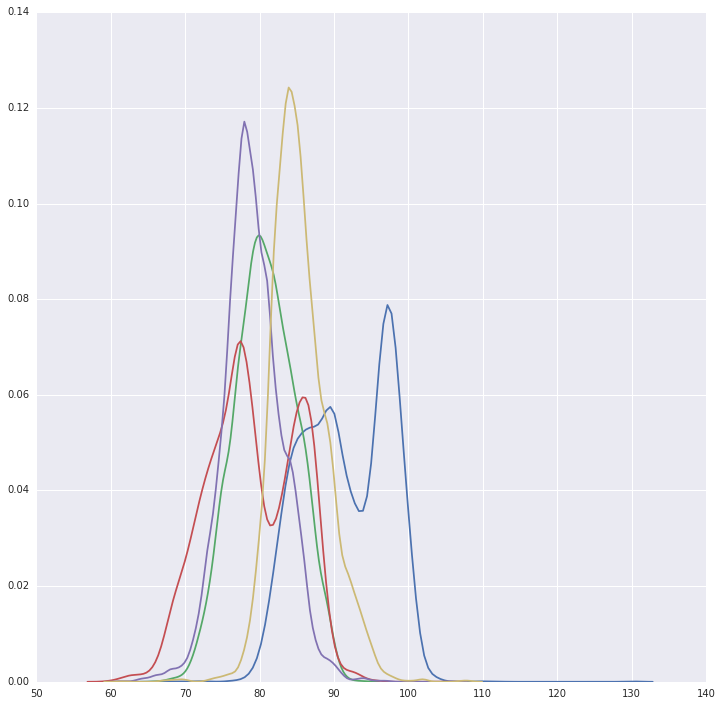

In [84]:
plt.figure(figsize=(12,12))
for j in range(5):
    sns.distplot(final['val'].iloc[j], hist = False)

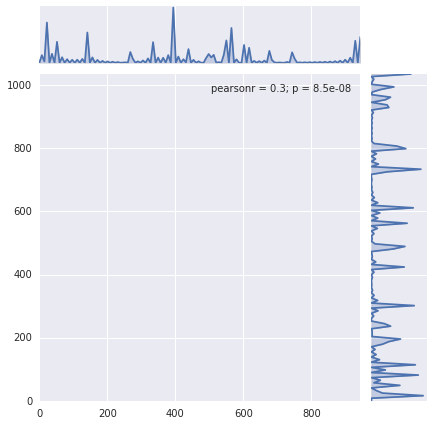

In [69]:
sns.JointGrid(x=final['hist'].iloc[0], y=final['hist'].iloc[1], xlim = (0, 300), kind="kde");